# Intro to PyTorch

The method for making a PyBuda Model that we're going to work with is wrapping a PyTorch model using the pybuda.PyTorchModule() function, as it is the fastest way to get a custom model up and running. 

```python
torch_model = Some_PyTorchModule_Here()
buda_model = pybuda.PyTorchModule("direct_pt", torch_model)
output = buda_model.run(input1, input2)
```

Which incidentally means that we're going to be doing a lot of PyTorch learning and then only at the very end, we're going to put it on tenstorrent hardware.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
tensor_1 = torch.Tensor([1,2,3])
tensor_2 = torch.Tensor([4,5,6])

In [ ]:
output = torch.dot(tensor_1, tensor_2)
print(output)

In [ ]:
i_matrix_manual = torch.Tensor([[1,0],[0,1]])
i_matrix_command = torch.eye(2)

In [ ]:
torch.matmul()

In [ ]:
def useful_tensor_functions(input_tensor):
    # get the number of features per dimension
    shape = input_tensor.shape()
    print('Tensor shape: ', shape)
    # Changes the number of dimensions in the tensor
    # if n > 0, that is the number of features per dimension
    # if n = -1, it will fill the dimension until it cannot anymore
    view = tensor_1.view(1,1,1,1,1,1,1,1,1,-1)
    # Adds another dimension to the tensor
    unsqueezed = tensor_1.unsqueeze()
    print('Unsqueezed tensor: ', unsqueezed)
    # Removes the outer most dimension from the tensor
    squeezed = tensor_1.squeeze()
    print('Squeezed tensor: ', squeezed)

In [ ]:
useful_tensor_functions(tensor_1)

### Defining a model

In [2]:
# While it is possible to build your own model from pytorch functions, it is much easier to make a child instance of the torch.nn.Module class
class ExampleMNISTModel(torch.nn.Module):
    def __init__(self) -> None:
        # There's two methods to building the feed forward aspect of your model, this definition is using a more sequential approach
        super().__init__()
        self.debug = False
        # All of the hidden layers in the network
        self.l1 = nn.Linear(784, 100)
        self.bn_1 = nn.BatchNorm1d(100)
        self.l2 = nn.Linear(100, 50)
        self.bn_2 = nn.BatchNorm1d(50)
        self.l3 = nn.Linear(50, 10)
        # Non linear activation function
        self.sigmoid = nn.Sigmoid()
        # Normalization is useful for multiple reasons:
        #  - improves accuracy
        #  - reduces the impact of outliers in the dataset
        
    def forward(self, input: torch.Tensor, batch_size: int):
        # Easier to understand for people coming from non-ML backgrounds
        if not self.debug:
            input = input.view(batch_size,-1)
            x = self.l1(input)
            x = self.sigmoid(x)
            x = self.bn_1(x)
            x = self.l2(x)
            x = self.sigmoid(x)
            x = self.bn_2(x)
            x = self.l3(x)
            x = self.sigmoid(x)
            return x
        else:
            input = input.view(batch_size,-1)
            print('pre l1: ', input.shape)
            x = self.l1(input)
            print('l1: ', x.shape)
            x = self.sigmoid(x)
            print('sigmoid: ', x.shape)
            x = self.bn_1(x)
            print('bn1: ', x.shape)
            x = self.l2(x)
            print('l2: ', x.shape)
            x = self.sigmoid(x)
            print('sigmoid: ', x.shape)
            x = self.bn_2(x)
            print('bn2: ', x.shape)
            x = self.l3(x)
            print('l3: ', x.shape)
            x = self.sigmoid(x)
            print('sigmoid: ', x.shape)
            return x

In [ ]:
# The less intuitive, more succinct method. Either model will work.
class ExampleMNISTModel_2(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = torch.nn.Sequential(
            nn.Linear(784, 100),
            nn.Sigmoid(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 50),
            nn.Sigmoid(),
            nn.BatchNorm1d(50),
            nn.Linear(50, 10),
            nn.Sigmoid(),
        )
        
    def forward(self, input: torch.Tensor, batch_size: int):
        input = input.view(batch_size,1,-1)
        return self.main(input)

This is where we definne an instance of our model that we built above, loss function for telling our model how wrong it was, as well as our optimizer function to perform backwards propagation on the model based on the loss function

In [3]:
learning_rate = 1E-4
model = ExampleMNISTModel()
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1E-6)

This one line of code can speed up training of your model by A LOT (assuming that you have a CUDA compatible card). When I was training GANs, it wasn't uncommon to see an 8x speedup on the training time.

In [87]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Datasets

Here we're going to be defining and playing around with all of the data that we're going to be using.

In [ ]:
train_batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True)
train_iter = iter(train_loader)
data, target = next(train_iter)

print(data.shape)
print(target.shape)

In [ ]:
import functools
def get_last(iterable):
    functools.reduce(lambda _, x : x, iterable)

data, target = get_last(train_iter)

print('Because we chose a batch size that the dataset isnt a common factor of, we get the following shapes for the last batch of data: ')
print('data.shape: ', data.shape)
print('target.shape: ', target.shape)

These are the loaders that we will be using for the dataset

In [4]:
train_batch_size = 64
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle=True)

test_batch_size = 1000
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size = test_batch_size, shuffle=False)


### Helper functions for visualizing training

I've defined a couple of helper functions in [utils/graph_viz.py](./utils/graph_viz.py). If you would like to look more into them, you're more than welcome to. However, it is not necessary to learning how to build models.

In [5]:
from utils.graph_viz import graph_loss, make_confusion_matrix_given_model
import time

## The most basic training loop

In [7]:
# constants
epochs = 10

In [8]:
# set the model into training mode
model.train()
training_loss = []

# purely for timing
start_time = time.perf_counter()

# loop through all of the epochs
for epoch in range(1,epochs+1):
    print('Epoch #',epoch)
    num_of_batches = len(train_loader)
    
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # sometimes our batch size doesn't exactly match up to the size of the dataset, so we can either skip the last batch or make the last batch smaller
        batch_size = data.size(0)
        # Option 1: skip as defined below. Option 2: is to pass the batch size into the model
        # if batch_size != train_batch_size:
        #     continue
        
        # resets all of the gradients of the weights inside of the model
        # as a rule of thumb, if you forget to do this, the model will never get beyond 50% accuracy
        # the gradients for the model will accumulate to be the most average  
        optimizer.zero_grad()
        
        # this is where all of the magic happens
        output = model(data, batch_size)
        
        # print('output shape: ', output.shape)
        # print('target shape: ', target.shape)
        
        # the difference between what we the predicted output would be and the actual value
        loss = loss_func(output, target)
        
        # for seeing whats going on inside of the model
        epoch_loss += loss.item()
        
        # back propagation 
        loss.backward()
        
        # take one step, in the size of the learning rate towards a lower loss function
        optimizer.step()
    
    epoch_loss /= num_of_batches
    print('Training Loss: ', epoch_loss)
    training_loss.append(epoch_loss)
end_time = time.perf_counter()

total_time = end_time - start_time
print(f'Training Took {total_time:.1f} seconds')

# set the model into eval mode, making the model run faster, as we don't restructure the data locality around back propagation weights
# model.eval()

Epoch # 1
Training Loss:  1.8879141011980296
Epoch # 2
Training Loss:  1.7741553271248904
Epoch # 3
Training Loss:  1.6872360190348838
Epoch # 4
Training Loss:  1.624613991424219
Epoch # 5
Training Loss:  1.5925268004698032
Epoch # 6
Training Loss:  1.5746970587193585
Epoch # 7
Training Loss:  1.562840801820572
Epoch # 8
Training Loss:  1.5542023736022428
Epoch # 9
Training Loss:  1.5473806753849932
Epoch # 10
Training Loss:  1.542106717380125
Training Took 24.4 seconds


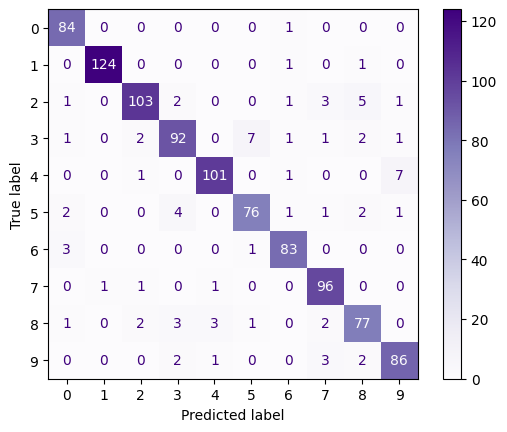

In [9]:
make_confusion_matrix_given_model(model)

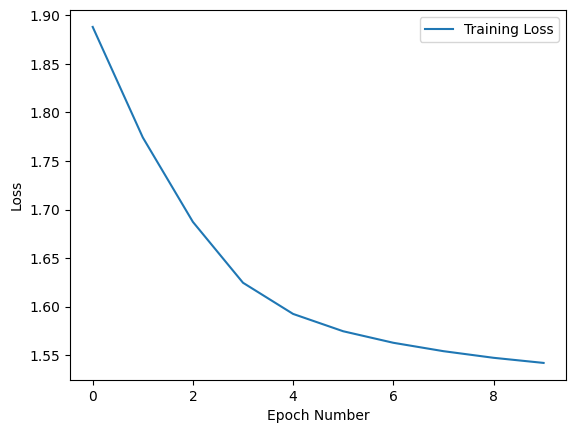

In [10]:
graph_loss(**{"Training Loss": training_loss})